<a href="https://colab.research.google.com/github/paavni-27/Adobe_Gensolve/blob/main/adobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps:



### 1. Load the CSV Data:


*   Use the provided read_csv function to load curve data from CSV files.



### 2. Curve Regularization:

*   Identify straight lines, circles, ellipses, rectangles, polygons, and star shapes in the curve data.
*   Regularize these shapes to fit ideal geometric shapes.


### 3. Symmetry Detection:


*     Detect symmetry in closed curves by identifying lines of symmetry.

*   Utilize symmetry for curve regularization.

### 4. Curve Completion:


*   Implement algorithms to complete curves that are partially occluded.



### 5. Visualization:
  * Use matplotlib for visualizing the curves and the results of regularization and symmetry detection.
  * Convert the processed curves into SVG and PNG formats for further analysis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install svgwrite
!pip install cairosvg
import svgwrite
import cairosvg

# Define color map for visualization
colours = ['red', 'green', 'blue', 'orange', 'purple']


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs


In [ ]:
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()


In [ ]:
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))

    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H,
                     output_width=fact*W, output_height=fact*H, background_color='white')

    return png_path


## Step 1: Reading the CSV files


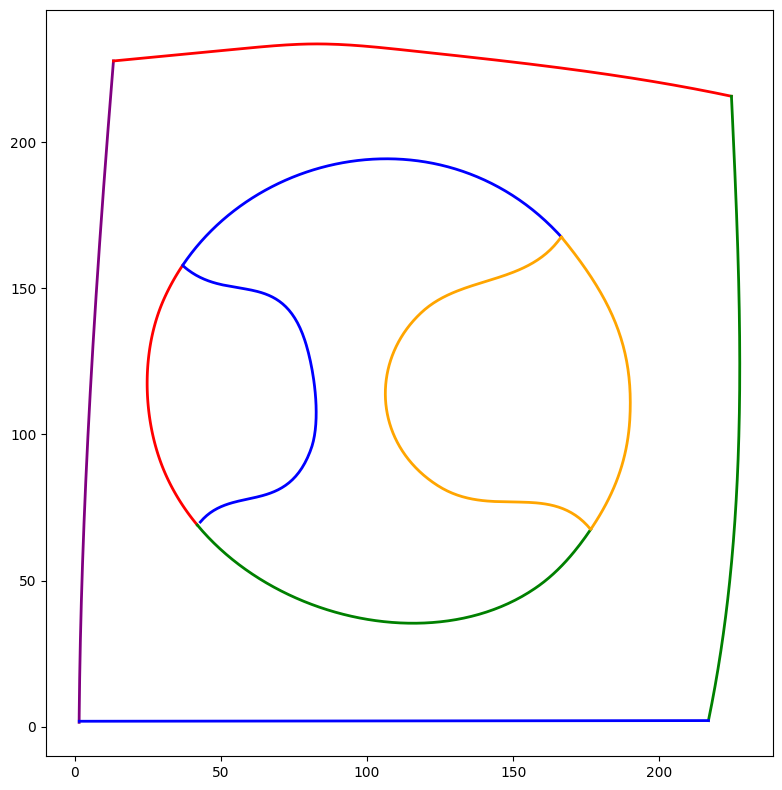

SVG and PNG files have been saved: frag1_output.svg, frag1_output.png


In [ ]:
# Read the input CSV files
input_path = 'frag1.csv'
output_svg = 'frag1_output.svg'

paths_XYs = read_csv(input_path)

# Plot the polylines
plot(paths_XYs)

# Convert the polylines to SVG and PNG
output_png = polylines2svg(paths_XYs, output_svg)

print(f"SVG and PNG files have been saved: {output_svg}, {output_png}")


## Step-2: Curve Regularization


In [ ]:
# regularize curves: Regularizing Identified Curves
from scipy.spatial import ConvexHull
from sklearn.linear_model import LinearRegression

def regularize_curves(path_XYs):
    regularized_paths = []
    for path in path_XYs:
        regularized_path = []
        for XY in path:
            if is_line(XY):
                XY = regularize_line(XY)
            elif is_circle(XY):
                XY = regularize_circle(XY)
            elif is_polygon(XY):
                XY = regularize_polygon(XY)
            regularized_path.append(XY)
        regularized_paths.append(regularized_path)
    return regularized_paths




In [ ]:
def is_line(XY):
 # Check if the points form a straight line using linear regression
 model = LinearRegression().fit(XY[:, 0].reshape(-1, 1), XY[:, 1])
 score = model.score(XY[:, 0].reshape(-1, 1), XY[:, 1])
 return score > 0.99


def regularize_line(XY):
 # Regularize a line by fitting a straight line to the points
 model = LinearRegression().fit(XY[:, 0].reshape(-1, 1), XY[:, 1])
 y_pred = model.predict(XY[:, 0].reshape(-1, 1))
 return np.column_stack((XY[:, 0], y_pred))


def is_circle(XY):
 # Check if the points approximate a circle
 x_m, y_m = np.mean(XY, axis=0)
 distances = np.sqrt((XY[:, 0] - x_m) ** 2 + (XY[:, 1] - y_m) ** 2)
 return np.std(distances) < 0.05 * np.mean(distances)


def regularize_circle(XY):
 # Regularize points to fit a circle
 x_m, y_m = np.mean(XY, axis=0)
 distances = np.sqrt((XY[:, 0] - x_m) ** 2 + (XY[:, 1] - y_m) ** 2)
 r = np.mean(distances)
 angles = np.arctan2(XY[:, 1] - y_m, XY[:, 0] - x_m)
 return np.column_stack((x_m + r * np.cos(angles), y_m + r * np.sin(angles)))


def is_polygon(XY):
 # Check if the points approximate a polygon using the convex hull
 hull = ConvexHull(XY)
 return len(hull.vertices) == len(XY)

def regularize_polygon(XY):
 # Regularize points to form a polygon using the convex hull
 hull = ConvexHull(XY)
 return XY[hull.vertices]

## Step-3: Symmetry Detection


In [ ]:
# 3. detect_symmetry: Detecting Symmetry in Curves
from scipy.spatial.distance import cdist
def detect_symmetry(path_XYs):
    symmetrized_paths = []
    for path in path_XYs:
        symmetrized_path = []
        for XY in path:
            if is_symmetric(XY):
                XY = symmetrize_curve(XY)
            symmetrized_path.append(XY)
        symmetrized_paths.append(symmetrized_path)
    return symmetrized_paths


def is_symmetric(XY):
    # Check if the curve has a line of symmetry
    x_m, y_m = np.mean(XY, axis=0)
    reflected = 2 * np.array([x_m, y_m]) - XY
    distances = cdist(reflected, XY)
    min_distances = np.min(distances, axis=1)
    return np.mean(min_distances) < 0.05


def symmetrize_curve(XY):
    # Symmetrize the curve by averaging it with its reflection
    x_m, y_m = np.mean(XY, axis=0)
    reflected = 2 * np.array([x_m, y_m]) - XY
    return (XY + reflected) / 2

## Step-4 : Curve Completion


In [ ]:
# 4. complete_curves: Completing Incomplete Curves
from scipy.interpolate import interp1d
def complete_curves(path_XYs):
    completed_paths = []
    for path in path_XYs:
        completed_path = []
        for XY in path:
            if is_incomplete(XY):
                XY = complete_curve(XY)
            completed_path.append(XY)
        completed_paths.append(completed_path)
    return completed_paths


def is_incomplete(XY):
    # Check if the curve is incomplete by comparing the distance between first and last points
    return np.linalg.norm(XY[0] - XY[-1]) > 0.1 * np.mean(np.linalg.norm(np.diff(XY, axis=0),
    axis=1))


def complete_curve(XY):
    # Complete the curve by interpolating between the first and last points
    t = np.linspace(0, 1, len(XY))
    f_x = interp1d(t, XY[:, 0], kind='cubic')
    f_y = interp1d(t, XY[:, 1], kind='cubic')
    t_new = np.linspace(0, 1, len(XY) + 20)
    return np.column_stack((f_x(t_new), f_y(t_new)))


from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d

## Step-5 : Visualization

<ipython-input-46-cfb907b4aecb>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colours = plt.cm.get_cmap('tab10', len(path_XYs))


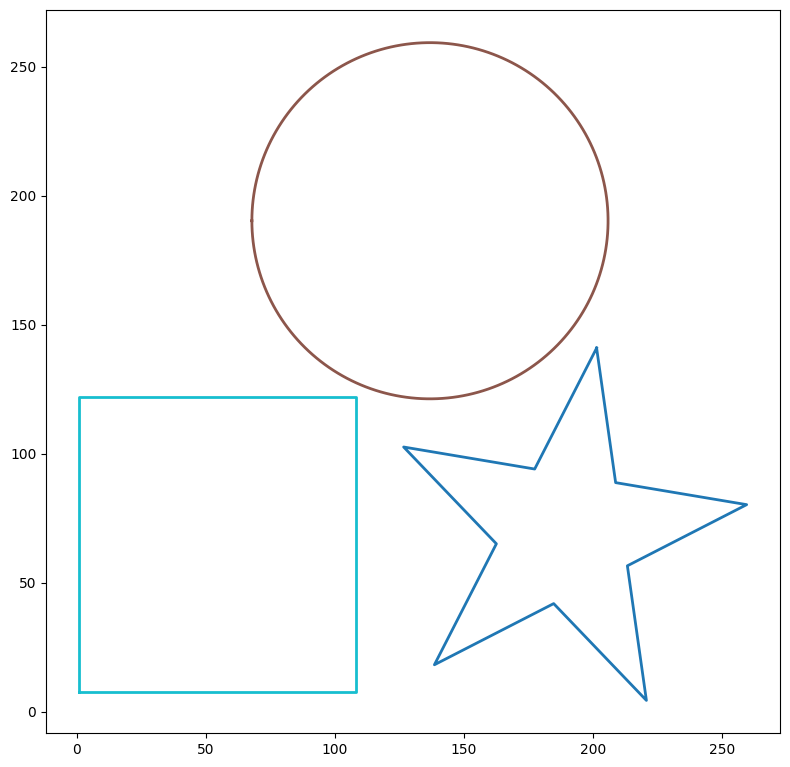

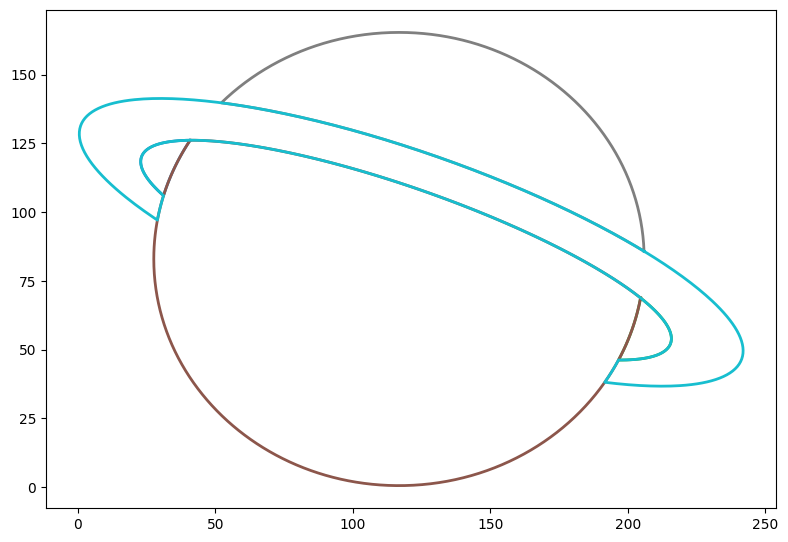

<ipython-input-47-19b5f4c1c604>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colours = plt.cm.get_cmap('tab10', len(path_XYs))


In [47]:

# Function to save polylines to SVG and PNG
def polylines2svg(path_XYs, svg_path):
    W, H = 0, 0
    for path in path_XYs:
        for XY in path:
            if XY.ndim == 2:  # Ensure XY is 2-dimensional
                W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = plt.cm.get_cmap('tab10', len(path_XYs))
    for i, path in enumerate(path_XYs):
        c = colours(i)
        # Convert RGBA tuple to hexadecimal color code
        fill_color = '#{:02x}{:02x}{:02x}'.format(int(c[0] * 255), int(c[1] * 255), int(c[2] * 255))
        for XY in path:
            if XY.ndim == 2:  # Ensure XY is 2-dimensional
                path_data = [("M", (XY[0, 0], XY[0, 1]))]
                for j in range(1, len(XY)):
                    path_data.append(("L", (XY[j, 0], XY[j, 1])))
                if not np.allclose(XY[0], XY[-1]):
                    path_data.append(("Z", None))
                group.add(dwg.path(d=path_data, fill=fill_color, stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact * W, output_height=fact * H,
                     background_color='white')


# Load CSV data
isolated_paths = read_csv('/content/isolated_sol.csv')
occlusion_paths = read_csv('/content/occlusion2.csv')

# Regularize Curves
regularized_isolated_paths = regularize_curves(isolated_paths)

# Detect Symmetry
symmetrized_isolated_paths = detect_symmetry(regularized_isolated_paths)

# Complete Curves
completed_occlusion_paths = complete_curves(occlusion_paths)

# Plot and visualize the results
plot(symmetrized_isolated_paths)
plot(completed_occlusion_paths)

# Save results to SVG and PNG
polylines2svg(symmetrized_isolated_paths, 'isolated_output.svg')
polylines2svg(completed_occlusion_paths, 'occlusion_output.svg')